## MC Simulation

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pydicom
from scipy.interpolate import interp1d

# Paths to files
basepath = "./pregnant_woman_dataset"
dicom_folder_path = basepath+"/pregnant_patient_models/image_data/FETUS_2"  # Path to DICOM folder
tcm_file_path = basepath+"/pregnant_patient_models/tcm_files/fetus2_tcm.txt"
size_topo_path = basepath+"/pregnant_patient_models/size_metrics/topo/fetus2_topo_size.txt"
image_size_path = basepath+"/pregnant_patient_models/size_metrics/image/fetus2_image_size.txt"
equivalent_source_cdf_path = basepath+"/scanner_characteristics/Siemens_SOMATOM_Definition_AS/spectra_cdf/as64_120_w1_opt_spec.txt"
bowtie_filter_file_path=basepath+"/scanner_characteristics/Siemens_SOMATOM_Definition_AS/bowtie_filtration_profiles/as64_120_w1_opt_filt.txt"

In [ ]:
# Load DICOM voxel model
def load_dicom_voxel_model(dicom_folder):
    print("Loading DICOM voxel model data...")
    dicom_files = [os.path.join(dicom_folder, f) for f in os.listdir(dicom_folder) if f]
    dicom_files.sort()  # Ensure files are ordered by slice position
    
    # Load the first DICOM file to get image dimensions
    sample_dicom = pydicom.dcmread(dicom_files[0])
    if 'KVP' in sample_dicom:
        tube_voltage = sample_dicom.KVP  # Tube voltage in kVp
        print(f"Tube voltage found: {tube_voltage}")
    else:
        print(f"Tube voltage not found in file")
        tube_voltage = 120  # Default value, adjust as necessary


    img_shape = (len(dicom_files), sample_dicom.Rows, sample_dicom.Columns)
    
    # Initialize the voxel model array
    voxel_model = np.zeros(img_shape, dtype=float)
    
    # Load each slice into the voxel model
    for i, file in enumerate(dicom_files):
        ds = pydicom.dcmread(file)
        voxel_model[i, :, :] = ds.pixel_array
    
    print("DICOM voxel model loaded with shape:", voxel_model.shape)
    return voxel_model

# Load TCM profile
def load_tcm_profile(file_path):
    print("Loading TCM profile...")
    tcm_data = pd.read_csv(file_path, delimiter=" ", skiprows=1, header=None,
                           names=["z", "theta", "current"])
    print("TCM profile loaded with shape:", tcm_data.shape)
    return tcm_data

# Load size metrics (fetal depth and patient perimeter)
def load_size_topo(file_path):
    print("Loading size topo data...")
    size_data = pd.read_csv(file_path, header=None, names=["index", "AP", "LAT", "Dw"])
    print("Size topo data loaded with shape:", size_data.shape)
    return size_data

# Load image size data (Dw) from text file
def load_image_size(file_path):
    print("Loading image size data...")
    with open(file_path, 'r') as f:
        image_size_data = [float(line.strip()) for line in f]
    print("Image size data loaded with length:", len(image_size_data))
    return image_size_data

# Load Equivalent Source CDF
def load_equivalent_source_cdf(file_path):
    print("Loading equivalent source CDF...")
    cdf = np.loadtxt(file_path)  # Load cumulative probabilities
    energies_keV = np.arange(1, len(cdf) + 1)  # Energies from 1 keV to 140 keV
    print(f"Equivalent source CDF loaded with {len(cdf)} energy bins.")
    return energies_keV, cdf

# Load bowtie filter profile
def load_bowtie_filter_profile(file_path):
    print("Loading bowtie filter profile...")
    data = np.loadtxt(file_path)
    path_lengths_cm = data[:, 0]  # Equivalent path length of aluminum in cm
    fan_half_angles_deg = data[:, 1]  # Fan half-angle in degrees
    print(f"Bowtie filter profile loaded with {len(path_lengths_cm)} entries.")
    return path_lengths_cm, fan_half_angles_deg

# Tissue densities based on dataset documentation
tissue_densities = {
    50: 0.00,   # air
    51: 0.05,   # lung
    52: 0.13,   # lung
    53: 0.30,   # lung
    54: 0.47,   # lung
    55: 0.65,   # lung
    56: 0.85,   # fat or soft tissue
    57: 0.93,   # fat or soft tissue
    58: 0.98,   # fat or soft tissue
    59: 1.00,   # water
    60: 1.06,   # muscle
    61: 1.14,   # muscle
    62: 1.26,   # muscle
    63: 1.48,   # bone
    64: 1.68,   # bone
    65: 1.89,   # bone
    66: 2.10,   # bone
    89: 1.48,   # fetal bone
    90: 1.06,   # fetal tissue
    91: 1.00,   # gestational sac
    92: 1.14    # uterus
}

In [144]:
# Load all necessary data
# Fetus 2 scan length - 46 cm

voxel_model = load_dicom_voxel_model(dicom_folder_path) # 92 x 512 x 512 , actual measurement: 5mm x 0.6 mm x 0.6 mm
tcm_profile = load_tcm_profile(tcm_file_path) # 4591 x z(0.1mm) x theta(0-360) x current (mA)
size_data = load_size_topo(size_topo_path) # 460 x AP x LAT x Dw(cm) (resolution - 1mm)
image_size_data = load_image_size(image_size_path) # 92 x Dw(cm)
energies_keV, cdf = load_equivalent_source_cdf(equivalent_source_cdf_path) # 140 bins

Loading DICOM voxel model data...
Tube voltage found: 120
DICOM voxel model loaded with shape: (92, 512, 512)
Loading TCM profile...
TCM profile loaded with shape: (4591, 3)
Loading size topo data...
Size topo data loaded with shape: (461, 4)
Loading image size data...
Image size data loaded with length: 92
Loading equivalent source CDF...
Equivalent source CDF loaded with 140 energy bins.


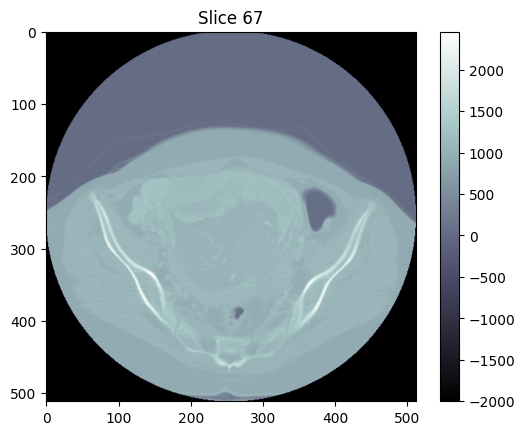

In [150]:
#plot an example slice
slice_index = 67
slice_data = voxel_model[slice_index, :, :]
slice_data = slice_data.astype(int)

plt.imshow(slice_data, cmap='bone')
plt.colorbar()
plt.title(f"Slice {slice_index}")
plt.show()

In [151]:
# Constants for Monte Carlo simulation
SID = 595.0  # Source-to-Image Distance in mm (fixed)
slice_thickness = 5.0  # Slice thickness in mm
beam_central_angle = 360  # Full rotation (360 degrees)
voxel_size = [2.4, 2.4, 5.0]  # Voxel dimensions in mm (assuming 1x1x1 mm^3)
mu_water = 0.22 # Linear attenuation coefficient for water at 120keV

# Function to sample photon energies from the cumulative distribution
def sample_photon_energies(num_photons):
    random_probs = np.random.rand(num_photons)
    energies = np.interp(random_probs, cdf, energies_keV)
    return energies


# Function to calculate physical coordinates from pixel indices
def get_voxel_coordinates(row, col, image_position, image_orientation, pixel_spacing):
    # Direction cosines
    row_cosines = image_orientation[:3]
    col_cosines = image_orientation[3:]
    
    # Pixel spacing
    row_spacing, col_spacing = pixel_spacing
    
    # Calculate the voxel coordinates in patient space
    voxel_position = (
        image_position
        + row_cosines * row * row_spacing
        + col_cosines * col * col_spacing
    )
    x_v, y_v, z_v = voxel_position
    return x_v, y_v, z_v

# Monte Carlo dose estimation function
def monte_carlo_dose_estimation(x_v, y_v, z_v, hu, num_photons, Dw):
    # Initialize total energy deposited in the voxel
    total_energy_deposited = 0.0  # in keV

    #normalize the hounsfield unit to water
    mu = mu_water * (hu / 1000) + mu_water
    
    #get tissue density from HU
    tissue_density = 1 + (hu / 1000)

    # Source position (rotating around the isocenter)
    # For a helical scan, the source moves along a helical path
    # For simplicity, we'll simulate photons from all angles around the isocenter every 10 degrees
    for theta in range(0, beam_central_angle, 10):
        # Source position
        x_s = SID * np.cos(theta * np.pi / 180)
        y_s = SID * np.sin(theta * np.pi / 180)
        z_s = z_v  # Assuming source is at the same z-coordinate for this slice
        
        # Distance between source and voxel
        r = np.sqrt((x_s - x_v)**2 + (y_s - y_v)**2 + (z_s - z_v)**2)
        
        # Calculate attenuation along the path
        # Path length through the patient
        path_length = r  # Assuming straight-line path
        # Attenuation factor
        attenuation = np.exp(-mu_water * (path_length * Dw*10)/SID**2) # Convert path length to cm
        num_attenuated_photons = int(num_photons * attenuation)
        # print(f"Photon {theta+1}/{360}: Path Length={path_length:.2f} mm, Attenuation={attenuation:.4f}, Num Attenuated Photons={num_attenuated_photons}")

        # Sample photon energies
        energies = sample_photon_energies(num_attenuated_photons)
        for i in range(num_attenuated_photons):
            # Photon energy
            E = energies[i]
            
            # Probability of photon interacting in the voxel
            interaction_prob = (mu**3) * (E/120) / ((path_length/SID)**2)
            # print(f"Photon {i+1}/{num_photons}: Energy={E:.2f} keV, Path Length={path_length:.2f} mm, Attenuation={attenuation:.4f}, Interaction Prob={interaction_prob:.4f}")
            
            # Determine if the photon interacts in the voxel
            if np.random.rand() < interaction_prob:
                # Energy deposited in the voxel (assuming complete absorption)
                total_energy_deposited += E # in keV
    
    # Mass of the voxel
    voxel_volume_cm3 = np.prod(voxel_size) * 1e-3  # Convert mm^3 to cm^3
    voxel_mass = voxel_volume_cm3 * tissue_density # in grams
    
    return total_energy_deposited, voxel_mass


In [152]:
dicom_files = [os.path.join(dicom_folder_path, f) for f in os.listdir(dicom_folder_path) if f]
dicom_files.sort()  # Ensure files are ordered by slice position

#get the dose for all the voxels of a slice
def get_dose_for_slice(slice_index, num_photons):
    
    # Read DICOM image using pydicom
    ds = pydicom.dcmread(dicom_files[slice_index])

    # Get the pixel array (image data)
    pixel_array = ds.pixel_array
    # downsample the image to reduce the computation time
    pixel_array = pixel_array[::4, ::4]

    # Extract necessary DICOM attributes
    pixel_spacing = ds.PixelSpacing # [row_spacing, col_spacing] in mm
    # increase pixel spacing
    pixel_spacing = [4 * pixel_spacing[0], 4 * pixel_spacing[1]]

    image_position = np.array(ds.ImagePositionPatient).astype(float)  # [x0, y0, z0] in mm
    image_orientation = np.array(ds.ImageOrientationPatient).astype(float)  # [row_cosines, col_cosines]
    
    rows, cols = pixel_array.shape
    total_kev = np.zeros((rows, cols), dtype=float)
    total_mass = np.zeros((rows, cols), dtype=float)
    
    # Loop over all voxels in the slice
    for row in range(rows):
        for col in range(cols):
            # Get voxel coordinates
            x_v, y_v, z_v = get_voxel_coordinates(row, col, image_position, image_orientation, pixel_spacing)
            
            # Calculate dose for the voxel
            kev, mass = monte_carlo_dose_estimation(x_v, y_v, z_v, max(-1000, pixel_array[row][col]), num_photons, image_size_data[slice_index])

            total_kev[row, col] = kev
            total_mass[row, col] = mass

            # print(f"Calculating dose for voxel ({x_v:.2f}, {y_v:.2f}, {z_v:.2f}) mm: {dose:.6e} Gy")

    return total_kev, total_mass

# Calculate dose for the slice
total_e, total_m = get_dose_for_slice(slice_index, 100)


Image shape: (128, 128)


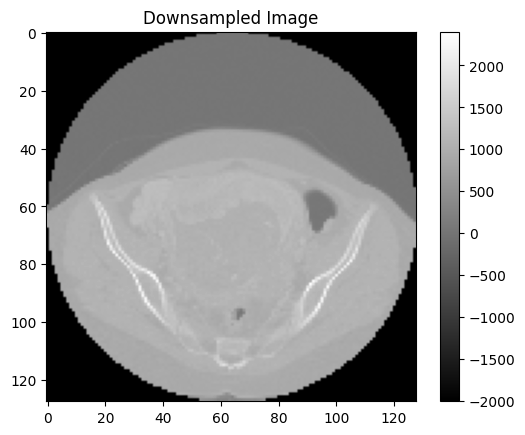

In [154]:
# plot downsampled slice image
downsampled_image = voxel_model[slice_index, ::4, ::4]
print("Image shape:", downsampled_image.shape)
plt.imshow(downsampled_image, cmap='gray')
plt.title("Downsampled Image")
plt.colorbar()
plt.show()

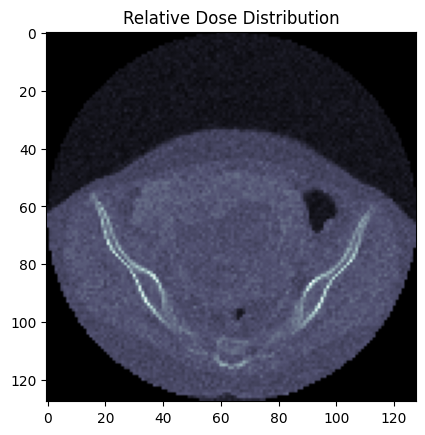

In [155]:
# Plot the dose distribution
# element wise division of total_e and total_mass to get the dose in Gy
# Dose = Energy / Mass
relative_dose = np.divide(total_e, total_m, out=np.zeros_like(total_e), where=total_m!=0)
plt.imshow(relative_dose, cmap='bone')
plt.title("Relative Dose Distribution")
plt.show()

In [168]:
def calculate_dose(total_e, total_m):
    # calculate total meV/g per photon
    total_mev = np.sum(total_e) * 1e-3 # convert to MeV
    total_mass = np.sum(total_m)
    total_mev_g = total_mev / (total_mass * 36 * 128 * 128 * 100) # 100 photons per voxel, 36 angles per 1 rotation, 128 x 128 voxels per slice

    # calculate absolute dose
    NF = 7.759e+10 #from the dataset
    mev_to_mgy = 1.602e-7 #conversion factor
    effective_mAs = 200 #from the dataset
    absolute_dose = total_mev_g * NF * mev_to_mgy * effective_mAs  # in mGy, formula from the dataset's documentation

    # Calculate CTDI vol Normalized slice dose
    ctdi_vol = 15.6 # from the dataset
    ctdi_vol_normalized_dose = absolute_dose / ctdi_vol

    return absolute_dose, ctdi_vol_normalized_dose

abs_dose, norm_dose = calculate_dose(total_e, total_m)
print(f"Absolute Dose of slice: {abs_dose:.2f} mGy")
print(f"CTDI vol Normalized slice dose: {norm_dose:.2f}")

Absolute Dose of slice: 7.40 mGy
CTDI vol Normalized slice dose: 0.47


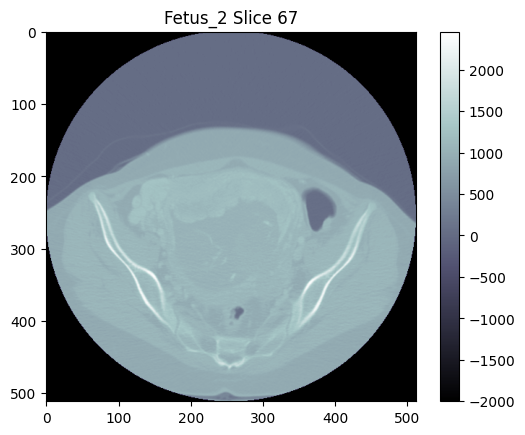

In [158]:
#plot the original voxel image slice
plt.imshow(voxel_model[slice_index, :, :], cmap='bone')
plt.colorbar()
plt.title(f"Fetus_2 Slice {slice_index}")
plt.show()

## Testing individual functions and intermediate values

In [ ]:
# test get voxel coordinates
row = 0
col = 0
# Read DICOM image using pydicom
ds = pydicom.dcmread(dicom_files[91])
image_position = np.array(ds.ImagePositionPatient).astype(float)  # [x0, y0, z0] in mm
image_orientation = np.array(ds.ImageOrientationPatient).astype(float)  # [row_cosines, col_cosines]
print("Image position:", image_position)
print("Image orientation:", image_orientation)
 # Extract necessary DICOM attributes
pixel_spacing = ds.PixelSpacing # [row_spacing, col_spacing] in mm
# increase pixel spacing
pixel_spacing = [4 * pixel_spacing[0], 4 * pixel_spacing[1]]

# Get the pixel array (image data)
pixel_array = ds.pixel_array
# subsample the image to reduce the computation time
pixel_array = pixel_array[::4, ::4]
x_v, y_v, z_v = get_voxel_coordinates(row, col, image_position, image_orientation, pixel_spacing)
print(f"Voxel coordinates for row {row}, col {col}: ({x_v:.2f}, {y_v:.2f}, {z_v:.2f}) mm")

Image position: [-145.800003 -155.       -402.36499 ]
Image orientation: [1. 0. 0. 0. 1. 0.]
Voxel coordinates for row 0, col 0: (-145.80, -155.00, -402.36) mm


In [160]:
print(size_data)

     index        AP     LAT      Dw
0        0   0.50954   0.000   0.000
1        1  20.68800  22.836  21.736
2        2  20.88400  21.630  21.254
3        3  21.09500  21.593  21.342
4        4  21.16900  21.580  21.373
..     ...       ...     ...     ...
456    456  12.95600  31.759  20.285
457    457  13.08100  31.728  20.372
458    458  12.90300  31.772  20.247
459    459  13.05400  31.734  20.354
460    460   0.00000   0.000   0.000

[461 rows x 4 columns]


In [ ]:
print(image_size_data)

In [ ]:
print(voxel_model[slice_index, 200:300, 200:300])

[[1194. 1189. 1212. ...  897.  933. 1014.]
 [1194. 1202. 1215. ...  903.  932.  992.]
 [1217. 1209. 1201. ...  912.  925.  966.]
 ...
 [1251. 1243. 1206. ...  973.  942.  931.]
 [1221. 1188. 1119. ...  959.  914.  918.]
 [1145. 1086. 1012. ...  979.  919.  910.]]


## Plots

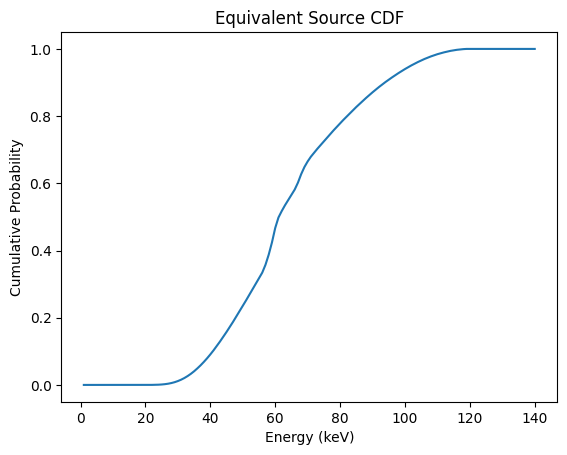

In [162]:
# print(energies_keV, cdf)
# plot the CDF
plt.plot(energies_keV, cdf)
plt.xlabel("Energy (keV)")
plt.ylabel("Cumulative Probability")
plt.title("Equivalent Source CDF")
plt.show()

Loading DICOM slices from: ./pregnant_woman_dataset/pregnant_patient_models/image_data/FETUS_2
Successfully read: ./pregnant_woman_dataset/pregnant_patient_models/image_data/FETUS_2/IM000001, shape: (512, 512)
Successfully read: ./pregnant_woman_dataset/pregnant_patient_models/image_data/FETUS_2/IM000002, shape: (512, 512)
Successfully read: ./pregnant_woman_dataset/pregnant_patient_models/image_data/FETUS_2/IM000003, shape: (512, 512)
Successfully read: ./pregnant_woman_dataset/pregnant_patient_models/image_data/FETUS_2/IM000004, shape: (512, 512)
Successfully read: ./pregnant_woman_dataset/pregnant_patient_models/image_data/FETUS_2/IM000005, shape: (512, 512)
Successfully read: ./pregnant_woman_dataset/pregnant_patient_models/image_data/FETUS_2/IM000006, shape: (512, 512)
Successfully read: ./pregnant_woman_dataset/pregnant_patient_models/image_data/FETUS_2/IM000007, shape: (512, 512)
Successfully read: ./pregnant_woman_dataset/pregnant_patient_models/image_data/FETUS_2/IM000008, sha

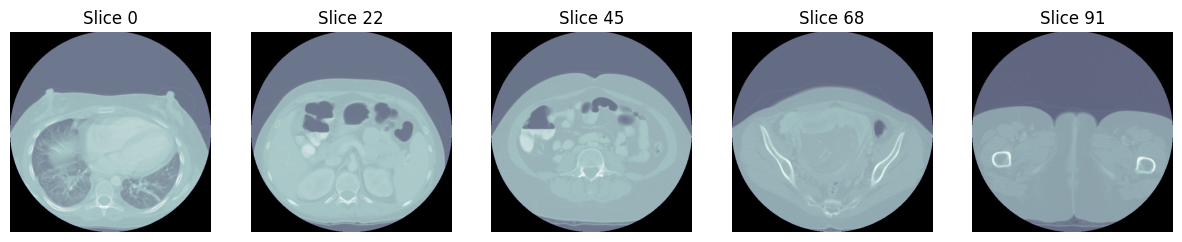

In [166]:
# Updated function to load DICOM slices from FETUS_2 folder
def load_dicom_slices(dicom_folder):
    print(f"Loading DICOM slices from: {dicom_folder}")
    dicom_files = [os.path.join(dicom_folder, f) for f in os.listdir(dicom_folder)]
    dicom_files.sort()  # Ensure files are ordered by slice position

    slices = []
    for file in dicom_files:
        try:
            # Attempt to read each file as a DICOM
            ds = pydicom.dcmread(file)
            slices.append(ds.pixel_array)
            print(f"Successfully read: {file}, shape: {ds.pixel_array.shape}")
        except Exception as e:
            # If a file cannot be read as a DICOM, skip it and print the error
            print(f"Failed to read {file} as DICOM. Error: {e}")

    print(f"Loaded {len(slices)} DICOM slices.")
    return slices

# Plotting function to visualize a few DICOM slices
def plot_dicom_slices(slices, num_slices=5):
    if not slices:
        print("No DICOM slices available to plot.")
        return

    fig, axs = plt.subplots(1, num_slices, figsize=(15, 5))
    slice_indices = np.linspace(0, len(slices) - 1, num_slices, dtype=int)

    for i, idx in enumerate(slice_indices):
        axs[i].imshow(slices[idx], cmap='bone')
        axs[i].set_title(f"Slice {idx}")
        axs[i].axis('off')

    plt.show()

# Load and plot the slices
ordered_slices = load_dicom_slices(dicom_folder_path)
plot_dicom_slices(ordered_slices, num_slices=5)


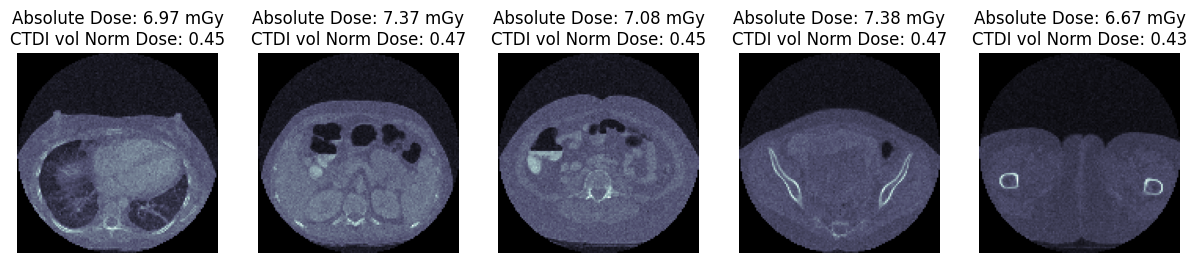

In [169]:
# Calculate dose for the slice
num_photons = 100
slice_indices = np.linspace(0, len(ordered_slices) - 1, 5, dtype=int)
relative_doses = []
abs_doses = []
norm_doses = []
for i, idx in enumerate(slice_indices):
    total_e_slice, total_m_slice = get_dose_for_slice(idx, num_photons)
    abs_dose, norm_dose = calculate_dose(total_e_slice, total_m_slice)
    relative_doses.append(np.divide(total_e_slice, total_m_slice, out=np.zeros_like(total_e_slice), where=total_m_slice!=0))
    abs_doses.append(abs_dose)
    norm_doses.append(norm_dose)

# calculate and plot the dose for a 10 random slices of the fetus
# Plotting function to visualize a few DICOM slices
def plot_relative_doses(dose_slices, abs_doses, norm_doses):
    fig, axs = plt.subplots(1, len(dose_slices), figsize=(15, 5))

    for i, slice in enumerate(dose_slices):
        axs[i].imshow(dose_slices[i], cmap='bone')
        axs[i].set_title(f"Absolute Dose: {abs_doses[i]:.2f} mGy\nCTDI vol Norm Dose: {norm_doses[i]:.2f}")
        axs[i].axis('off')

    plt.show()

plot_relative_doses(relative_doses, abs_doses, norm_doses)